
<center> <img src="figures/logos.png" style="width:450px">

<center> <font size="+2"> Tree Sequence Fundamentals: introduction to tskit, The Tree Sequence Toolkit </font>
<center> <font size="+1"> Anthony Wilder Wohns </font>
<center> <font size="+1"> Big Data Institute/Department of Statistics, University of Oxford </font>

Datasets of millions of genomes demand highly compact data structures and an efficient analysis toolkit.


Tree sequences and $\texttt{tskit}$ are our answer to this challenge.


$\texttt{tskit}$ includes a suite of tools for calculating common statistics of interest from tree sequences. Tree sequences can be simulated using $\texttt{msprime}$ and $\texttt{SLiM}$ are scalable coalescent and forwards time simulators. Finally, we can infer tree sequences from millions of samples using $\texttt{tsinfer}$.


We'll use the Python API for $\texttt{tskit}$ and $\texttt{msprime}$ to see how these tools work, how efficient they are, and how they can be used to answer questions you are interested in.

1. [tskit Python API](#ts)
2. [msprime Simulations</span>](#msprime)
3. [Tree Sequence Statistics</span>](#statistics)

In [1]:
import tsinfer
import tskit
import msprime
import io
import numpy as np
import matplotlib.pyplot as plt
import pysvg
import json
from IPython.display import SVG, display, HTML
import scipy
import seaborn as sns
import pandas as pd

nodes = io.StringIO("""\
id  is_sample   population  individual  time    metadata
0   1   0   -1  0.00000000000000    
1   1   0   -1  0.00000000000000    
2   1   0   -1  0.00000000000000    
3   1   0   -1  0.00000000000000    
4   1   0   -1  0.00000000000000    
5   1   0   -1  0.00000000000000    
6   0   0   -1  0.5   
7   0   0   -1  0.5   
8   0   0   -1  0.75 
9   0   0   -1  1.5
10  0   0   -1  1.5
11  0   0   -1  1.75
12  0   0   -1  2.5 
        """)
edges = io.StringIO("""\
id  left        right       parent  child
0   0.00000000  50.00000000 7   0
1   0.00000000  50.00000000 7   1
2   0.00000000  15          11   2
3   0.00000000  15          8   3
4   0.00000000  15          12   11
5   0.00000000  15          11   9
6   0.00000000  50          8   4
7   0.00000000  50          9   5
8   0.00000000  50          9  8
9   15  30          6  2
10   15  30          6  3
11   15  50          12  9
12  30  50 10  3
13  30  50 12  10
14  30  50 8  2
15  30  50 10  7
15  0  30 12  7
15  15  30 8  6
""")
sites = io.StringIO("""\
id  position    ancestral_state metadata
0   6 0   
1   12 0   
2   20 0 
3   40 0 
""")
mutations = io.StringIO("""\
id  site    node    derived_state   parent  metadata
0   0   0   1   -1  
1   1   11  1   -1  
2   2   8  1   -1 
3   3   10  1   -1 
""")
treeseq_example = tskit.load_text(nodes, edges, sites = sites, mutations = mutations, sequence_length=50, strict=False)


treeseq_example.dump('data/tree_sequence_example.trees')

In [2]:
def draw_tree_horizontal(ts):
    html = ''
    for tree in ts.trees():
        fraction_span = (tree.interval[1]-tree.interval[0])/tree.tree_sequence.sequence_length
        html += \
            '<td style="width: {}%">'.format(fraction_span*100) + \
                '<div">' + \
                    tree.draw() + \
                '</div>' + \
            '</td>'
    t1 = '<table><caption>Original ts</caption><tr>'+html+'</tr></table>'
    display(HTML(html))

# 1. [tskit Python API](#ts)


Let's get hands on with the python API as we familiarize ourselves with tree sequences. Note that a comprehensive documentation can be found at https://tskit.readthedocs.io/<br>


We'll start with the top level $\texttt{TreeSequence}$ class. 

In [3]:
import tskit
# Let's load the example we were just looking at as a tree sequence
treeseq_example = tskit.load("data/tree_sequence_example.trees")

Let's look again at the trees from the example above. The simpest way to do this is to print them one after another.
We can access each individual tree in the tree sequence with the .trees() function

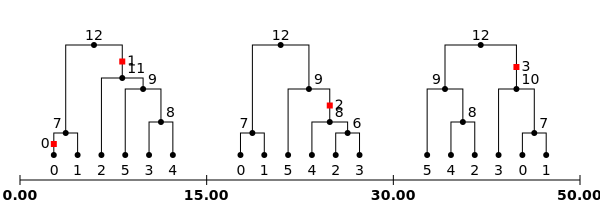

In [4]:
SVG(treeseq_example.draw_svg())

The `tskit` library allow us to use tree sequence objects in Python; these have specific properties and can also be queried using various methods. For example, we can easily show the number of trees in a tree sequence as follows 

In [5]:
treeseq_example.num_trees

3

We can also show the number of nodes, mutations and edges in the tree sequence

In [6]:
treeseq_example.num_nodes

13

In [7]:
treeseq_example.num_edges

18

In [8]:
treeseq_example.num_mutations

4

We can get the same information for each individual tree. All we need to do is iterate over the trees again

In [9]:
for tree in treeseq_example.trees():
    print('Tree', tree.index,'has:', tree.num_mutations, 'mutation(s)')


Tree 0 has: 2 mutation(s)
Tree 1 has: 1 mutation(s)
Tree 2 has: 1 mutation(s)


# Tables: The underlying infrastructure of a Tree Sequence
We'll understand how tree sequences are stored before getting hands-on with the API again 


![SegmentLocal](figures/mutations_gif.gif "segment")

![SegmentLocal](figures/edges_gif.gif "segment")

![SegmentLocal](figures/nodes_gif.gif "segment")

Since a tree sequence object is entirely specified by tables, these provide access to the internal representation of a tree sequence object. Below is a simple example of inspecting tables.

In [10]:
treeseq_example.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,-1,0.00000000000000,
1,1,0,-1,0.00000000000000,
2,1,0,-1,0.00000000000000,
3,1,0,-1,0.00000000000000,
4,1,0,-1,0.00000000000000,
5,1,0,-1,0.00000000000000,
6,0,0,-1,0.50000000000000,
7,0,0,-1,0.50000000000000,
8,0,0,-1,0.75000000000000,
9,0,0,-1,1.50000000000000,


In [11]:
treeseq_example.tables.edges

id,left,right,parent,child,metadata
0,15.00000000,30.00000000,6,2,
1,15.00000000,30.00000000,6,3,
2,0.00000000,50.00000000,7,0,
3,0.00000000,50.00000000,7,1,
4,30.00000000,50.00000000,8,2,
5,0.00000000,15.00000000,8,3,
6,0.00000000,50.00000000,8,4,
7,15.00000000,30.00000000,8,6,
8,0.00000000,50.00000000,9,5,
9,0.00000000,50.00000000,9,8,


In [12]:
treeseq_example.tables.mutations

id,site,node,derived_state,parent,metadata
0,0,0,1,-1,
1,1,11,1,-1,
2,2,8,1,-1,
3,3,10,1,-1,


The data in a table is itself stored as numpy arrays:

In [13]:
treeseq_example.tables.nodes.time

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.5 , 0.75, 1.5 , 1.5 ,
       1.75, 2.5 ])

We can also use the $\texttt{tskit}$ C API to work with tree sequences. Here we show a snippet from a Wright-Fisher simulator:

```C
child = tsk_node_table_add_row(&tables->nodes, 
   0, t, TSK_NULL, TSK_NULL, NULL, 0);
left_parent = parents[gsl_rng_uniform_int(rng, N)];
right_parent = parents[gsl_rng_uniform_int(rng, N)];
breakpoint = gsl_rng_uniform(rng);
tsk_edge_table_add_row(&tables->edges, 0, breakpoint, left_parent, child);
tsk_edge_table_add_row(&tables->edges, breakpoint, 1, right_parent, child);
```

# 2. msprime Simulations

1. [tskit Python API](#ts)
2. [msprime Simulations</span>](#msprime)
3. [Tree Sequence Statistics</span>](#statistics)

Tree sequences can be simulated using either a coalescent simulator, $\texttt{msprime}$, or a fowards time simulator, $\texttt{SLiM}$.

## Reverse-time simulations with $\texttt{msprime}$
The $\texttt{msprime}$ program is an efficient reimplementation of Hudson's $\texttt{ms}$ simulator which outputs coalescent trees using the tree sequence format. The easiest way to use it is through the Python API, which is well documented at https://msprime.readthedocs.io/en/stable/api.html. The citation is as follows: <br> Kelleher, Jerome, Alison M. Etheridge, and Gilean McVean. "Efficient coalescent simulation and genealogical analysis for large sample sizes." PLoS computational biology 12.5 (2016): e1004842.

Running simulations is very straightforward, and produces trees with branch lengths as expected under the full coalescent.

In [14]:
# simulate the coalescent for 6 samples, with effective population size of 10,000
# since the recombination rate defaults to zero, we should have only one tree
singular_tree_seq = msprime.simulate(sample_size=6, Ne=10000, random_seed=10)

# check there is only one tree in this ts
print("Number of Trees:",singular_tree_seq.num_trees)

Number of Trees: 1


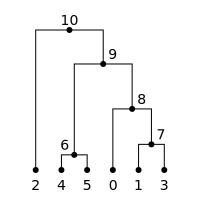

In [15]:
#take the first (only) tree and visualize
first_tree=singular_tree_seq.first()
SVG(first_tree.draw())

The `simulate()` function returns a standard `TreeSequence` object. Here there is only one tree because we have not provided a value for recombination_rate, which therefore defaults to zero. We can access the first (and only) tree in this sequence using `first()` method of a `TreeSequence` object.


We can also obtain the length of a branch joining a node to its parent using the `branch_length()` method; the total branch length in the tree is also stored in the `total_branch_length` attribute: 

In [16]:
node = 7
print("Branch length above node", node, "is", first_tree.branch_length(node))
print("Total branch length in tree is", first_tree.total_branch_length)

Branch length above node 7 is 4605.0710027482955
Total branch length in tree is 63385.43180380048


We can do the standard tree traverals using the ``nodes`` iterator:

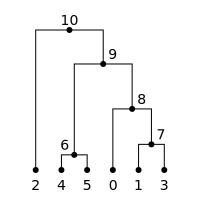

Default:	 [10, 2, 9, 6, 4, 5, 8, 0, 7, 1, 3]
Preorder:	 [10, 2, 9, 6, 4, 5, 8, 0, 7, 1, 3]
Inorder:	 [2, 10, 4, 6, 5, 9, 0, 8, 1, 7, 3]
Postorder:	 [2, 4, 5, 6, 0, 1, 3, 7, 8, 9, 10]


In [17]:
display(SVG(first_tree.draw()))
print("Default:\t", list(first_tree.nodes()))
print("Preorder:\t", list(first_tree.nodes(order="preorder")))
print("Inorder:\t", list(first_tree.nodes(order="inorder")))
print("Postorder:\t", list(first_tree.nodes(order="postorder")))

### Recombination
We are most often interested in simulating the history of our sample across large genomic regions under the influence of recombination. The msprime API is specifically designed to make this common requirement both easy and efficient. 

To model genomic sequences under the influence of recombination we have two parameters to the `simulate()` function. The length parameter specifies the length of the simulated sequence. The recombination_rate parameter specifies the rate of crossing over per unit of length per generation, and is zero by default.

Here, we simulate the trees across over a 10kb region with a recombination rate of 2×10−8 per base per generation, with a diploid effective population size of 1000:

--------------------
tree 0: interval = (0.0, 6173.258988692718)


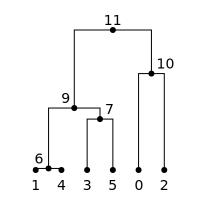

--------------------
tree 1: interval = (6173.258988692718, 10000.0)


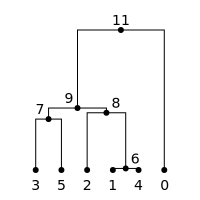

In [18]:
simple_tree_seq = msprime.simulate(
  sample_size=6, Ne=1000, length=1e4, recombination_rate=2e-8, random_seed=7)
for tree in simple_tree_seq.trees():
    print("-" * 20)
    print("tree {}: interval = {}".format(tree.index, tree.interval))
    display(SVG(tree.draw()))

As before, we use the `trees()` method to iterate over the trees in the sequence. For each tree we print out its index (i.e. its position in the sequence) and the interval the tree covers (i.e. the genomic coordinates which all share precisely this tree) using the index and interval attributes. Thus, the first tree covers the first 6kb of sequence, the second tree covers the remaining 4kb.

### Mutations
Mutations are generated in msprime by throwing mutations down on the branches of trees at a particular rate. The mutation rate for simulations is specified using the mutation_rate parameter of `simulate()`. For example, the following chunk simulates 50kb of nonrecombining sequence with a mutation rate of 1×10−8 per base per generation:

Num trees: 1
Mutation 0 @ position 1556.54 over node 9
Mutation 1 @ position 4485.17 over node 6
Mutation 2 @ position 9788.56 over node 6
Mutation 3 @ position 11759.03 over node 6
Mutation 4 @ position 11949.32 over node 6
Mutation 5 @ position 14321.77 over node 9
Mutation 6 @ position 31454.99 over node 6
Mutation 7 @ position 45125.69 over node 9
Mutation 8 @ position 49709.68 over node 6


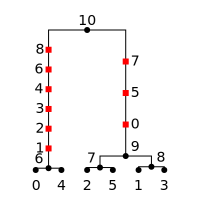

In [19]:
mut_tree_seq = msprime.simulate(
  sample_size=6, Ne=1000, length=50e3, mutation_rate=1e-8, random_seed=30)
print("Num trees:", mut_tree_seq.num_trees)
tree = mut_tree_seq.first()
for site in tree.sites():
    for mutation in site.mutations:
        print("Mutation {} @ position {:.2f} over node {}".format(
        mutation.id, site.position, mutation.node))
display(SVG(tree.draw()))

## Large simulations with $\texttt{msprime}$



One of the big advantages of msprime/tskit is that we can simulate and process genetic data on a very large scale. For example, here is a simulation of 100K human-like 10Mb chromosomes:

In [20]:
%%time
ts = msprime.simulate(
    sample_size=10**5, length=1e7, recombination_rate=1e-8, Ne=10**4, random_seed=20)

CPU times: user 4.46 s, sys: 62 ms, total: 4.52 s
Wall time: 4.53 s


In [21]:
print("Number of simulated trees: {}, Number of tips in each tree: {}".format(ts.num_trees, ts.num_samples))

Number of simulated trees: 45597, Number of tips in each tree: 100000


In [22]:
# Write the tree sequence to file.
ts.dump("data/large-ts-no-mutations.trees")

# Get the size
import os
print("File size = {}MiB".format(os.path.getsize("data/large-ts-no-mutations.trees") / 2**20))

File size = 16.758358001708984MiB


In [23]:
%%time
# Loading is fast
ts = msprime.load("data/large-ts-no-mutations.trees")

CPU times: user 13.4 ms, sys: 11.9 ms, total: 25.3 ms
Wall time: 25.5 ms


In [24]:
%%time
# So is iterating over all trees
total = 0  
for tree in ts.trees():
    total += tree.interval[1] - tree.interval[0] # Just to do *something* in the loop

print(total, ts.sequence_length)

10000000.0 10000000.0
CPU times: user 148 ms, sys: 4.23 ms, total: 152 ms
Wall time: 151 ms


In [25]:
%%time
# Insert a ridiculous number of mutations
mutated_ts = msprime.mutate(ts, rate=1e-6, random_seed=42) # deliberately high mutation rate

CPU times: user 12 s, sys: 1.22 s, total: 13.3 s
Wall time: 13.6 s


In [26]:
print("We just created {:,} variant sites!".format(mutated_ts.num_sites))

We just created 4,873,605 variant sites!


In [27]:
mutated_ts.dump("data/large-ts-mutations.trees")

print("Tree sequence size = {:.2f}MiB".format(os.path.getsize("data/large-ts-mutations.trees") / 2**20))
# PUT THIS IN GIGBYTES

Tree sequence size = 193.38MiB


In [28]:
print("Tree Sequence as a set of Newick Files is {}GiB".format((len(ts.first().newick()) * ts.num_trees) / 1e9))

Tree Sequence as a set of Newick Files is 191.201489727GiB


In [29]:
print("Genotype matrix size: {:.2f}GiB".format(
    mutated_ts.num_sites * mutated_ts.num_samples / 2**30))

Genotype matrix size: 453.89GiB


We can easily calculate statistics such as pairwise diversity with tskit

In [30]:
%%time
mutated_ts.pairwise_diversity()

CPU times: user 2.57 s, sys: 35.2 ms, total: 2.6 s
Wall time: 2.61 s


407924.0359974259

# 3. Tree Sequence Statistics
1. [tskit Python API](#ts)
2. [msprime Simulations</span>](#msprime)
3. [Tree Sequence Statistics</span>](#statistics)

In [31]:
with open("data/example.vcf", "w") as vcf_file:
    treeseq_example.write_vcf(vcf_file, ploidy=2)


In [32]:
import allel
callset = allel.read_vcf('data/example.vcf')

In [33]:
gt = allel.GenotypeArray(callset['calldata/GT'])

In [34]:
ac = gt.count_alleles()

In [35]:
ac[:,1]

array([1, 4, 3, 3], dtype=int32)

In [36]:
allel.sfs(ac[:,1])

array([0, 1, 0, 2, 1])

In [37]:
treeseq_example.allele_frequency_spectrum(span_normalise=False, polarised=True)

array([0., 1., 0., 2., 1., 0., 0.])

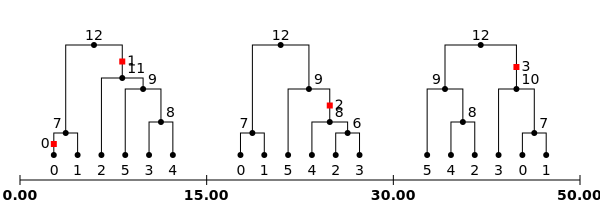

In [38]:
SVG(treeseq_example.draw_svg())

In [39]:
treeseq_example.genealogical_nearest_neighbours([3], [[0, 1], [2], [4, 5]])

array([[0.4, 0.3, 0.3]])

## *P. vivax* Example



We now use tsinfer on real data from the [ *P. vivax* Genome Variation Project](https://www.malariagen.net/projects/p-vivax-genome-variation), which contains 228 samples from 13 countries. Joe Zhu, formerly of the McVean group at Oxford, ran [Deploid](https://github.com/DEploid-dev/DEploid) on this dataset to identify 124 clonal samples. He then phased and imputed haplotypes for each strain.
<br> 


Since $\texttt{tsinfer}$ requires ancestral and derived alleles, Wilder used [$\texttt{Mauve}$](http://darlinglab.org/mauve/mauve.html) to create a multi-species alignment of the *vivax* genome to outgroups.  A rules-based maximum parsimony approach was used to determine ancestral alleles using this multi-species alignment. 
<br>
We have pre-made a SampleData object that $\texttt{tsinfer}$ requires to run Chromosome 1 of the 124 vivax samples. The data wrangling necessary when working with VCFs is thus kept under the hood.

In [40]:
vivax_inferred_ts = tskit.load("data/vivax_inferred_ts.trees")

In [41]:
vivax_inferred_ts.num_trees

1475

Let's visualise the first of the 1475 inferred marginal trees.

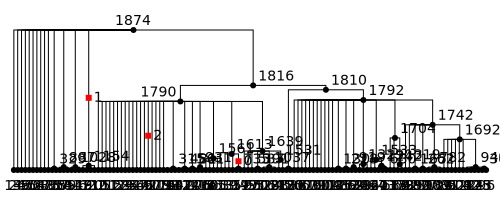

In [42]:
first_tree = vivax_inferred_ts.first()
SVG(first_tree.draw(width=500))

Clearly, with 124 samples, the tree is unintelligible. We can use the powerful [ete3 tree drawing engine](http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html) to draw the first tree with a circular output:

<img src="figures/circular_vivax_tree.png">


In [43]:
#if you're curious how this tree was created here is the code
#it won't run on jupyter hub however

# first_tree_newick=Tree(first_tree.newick())
# ts = TreeStyle()
# ts.mode = "c"
# ts.arc_start = 0 # 0 degrees = 3 o'clock
# ts.arc_span = 360
# #ts.scale = 20
# ts.show_leaf_name = True
# ts.show_scale = False
# first_tree_newick.render("%%inline",tree_style=ts,w=500)  

This is better, but it would be helpful to know where the samples came from!

Luckily the country of origin of the 124 sequences we are considering was stored in the vivax sample data file. Cleverly, this metadata has been transferred into the inferred tree sequence too, which we can query using the `populations()` iterator:

In [44]:
for p in vivax_inferred_ts.populations():
    print("Sample IDs from population", json.loads(p.metadata)['name'])
    print(vivax_inferred_ts.samples(population=p.id))

Sample IDs from population West Thailand
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
Sample IDs from population East Thailand
[51]
Sample IDs from population West Cambodia
[52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Sample IDs from population Northeast Cambodia
[72]
Sample IDs from population Indonesia
[73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Sample IDs from population Papua New Guinea
[ 97  98  99 100 101 102 103 104]
Sample IDs from population Brazil
[105]
Sample IDs from population Sri Lanka
[106]
Sample IDs from population Vietnam
[107 108 109 110 111 112 113]
Sample IDs from population India
[114]
Sample IDs from population Malaysia
[115 116 117 118 119]
Sample IDs from population Myanmar
[120]
Sample IDs from population Laos
[121]
Sample IDs from population Madagascar
[122]
Sample IDs from population China
[123]


We can use these to redraw the tree, coloring the tips by the country of origin. We won't show all the code here as it gets a bit messy, but here is the output:


<center> <img src="figures/malaria_circular.png"  style="width: 450px;"/>

This sort of representation at a region of interest could certainly be informative, but with 1475 marginal trees we need other ways to summarize the relationships between samples. 

## Genealogical Nearest Neighbours
A useful metric for understanding population level relationships from a tree sequence is genealogical nearest neighbours. 


Given K sets of reference nodes (e.g., the samples for each of the 15 populations of clonal *vivax* samples), the GNN statistic for a specific node is a K-vector describing the proportion of its immediate neighbours within the tree from each of these reference sets. <br>
Here is an example from the small example we've been working with.

In [45]:
# Define a reference set for each individual
reference_sets = [[0,1],[2,3],[4,5]]
pd.DataFrame(treeseq_example.genealogical_nearest_neighbours(treeseq_example.samples(),reference_sets),
             columns=["Individual_A","Individual_B","Individual_C"])


,Individual_A,Individual_B,Individual_C
0,1.0,0.00,0.00
1,1.0,0.00,0.00
2,0.0,0.40,0.60
3,0.4,0.30,0.30
4,0.0,1.00,0.00
5,0.0,0.55,0.45


<img src="figures/original_trees.png" width=700px>


Think of this as looking at the most recent ancestor of each sample and determining what population the other daughter sample(s) of that node came from.  
<br>



In the tsinfer preprint, we determined the GNN matrix for the UK Biobank. Here we show a much smaller example from the same clonal *vivax* dataset.

We begin by creating the reference set of populations for which the GNN statistic will be calculated.

In [46]:
import json
tables = vivax_inferred_ts.dump_tables()
reference_sets = []

for pop in vivax_inferred_ts.populations():
    reference_sets.append(np.where(tables.nodes.population == pop.id)[0].astype(np.int32))
    name = json.loads(pop.metadata.decode())["name"]

We then run the genealogical_nearest_neighbours function, converting the resulting array into a Pandas DataFrame and adding a Population column.

In [47]:
%%time
A = vivax_inferred_ts.genealogical_nearest_neighbours(
    vivax_inferred_ts.samples(), reference_sets)
gnn = pd.DataFrame(A)
gnn["Population"] = ""

CPU times: user 8.95 ms, sys: 2.25 ms, total: 11.2 ms
Wall time: 13.6 ms


We create a dictionary listing the samples belonging to each population from the metadata.

In [48]:
pop_dict = {}
for p in vivax_inferred_ts.populations():
    pop_dict[json.loads(p.metadata)['name']] = list(vivax_inferred_ts.samples(population=p.id))

We then use this dictionary to assign a population to each sample and rename the columns by the population they represent.

In [49]:
i = 0
for pop in pop_dict.items():
    for indiv in pop[1]:
        gnn.iloc[i,15] = pop[0]
        i += 1
gnn = gnn.rename(index=str, columns={v: k for v, k in enumerate(list(pop_dict.keys()))})

We keep populations with more than one sample.

In [50]:
gnn_removed_singletons=gnn[gnn["Population"].isin(['West Thailand','Indonesia',"West Cambodia","Papua New Guinea",
                                                   "Vietnam","Malaysia"])]
gnn_small = gnn_removed_singletons[['West Thailand','Indonesia',"West Cambodia","Papua New Guinea",
                                                   "Vietnam","Malaysia","Population"]]

We determine the Z-score normalised GNN proportions for clonal *vivax* samples by population. 
The GNN matrix is first z-score normalised by column and the rows are then hierarchically clustered.

In [51]:
dfg = gnn_small.groupby("Population").mean()

# Zscore normalise
for col in list(dfg):
    dfg[col] = scipy.stats.zscore(dfg[col])

row_linkage = scipy.cluster.hierarchy.linkage(dfg, method="average")
order = scipy.cluster.hierarchy.leaves_list(row_linkage)
x_pop = dfg.index.values[order]

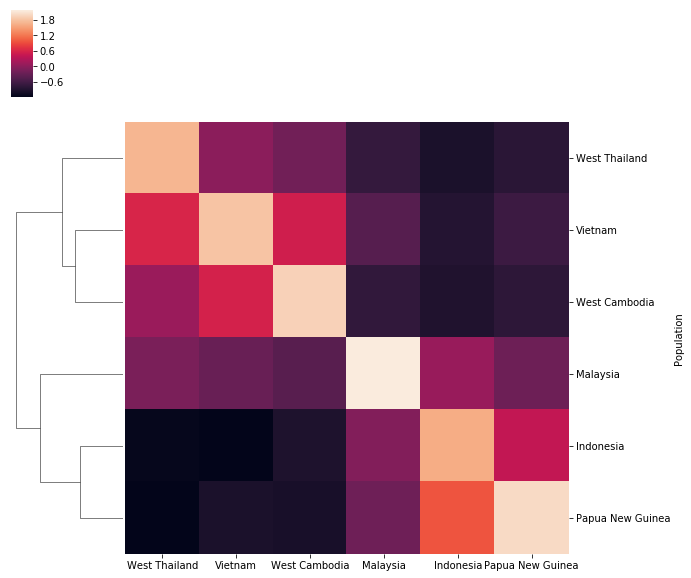

In [52]:
sns.clustermap(dfg[x_pop],row_linkage=row_linkage,col_cluster=False)

# References and Documentation

$\texttt{msprime}$: <br>
Reference: Kelleher, J., Etheridge, A.M. and McVean, G., 2016. Efficient coalescent simulation and genealogical analysis for large sample sizes. PLoS computational biology, 12(5), p.e1004842.
<br>
Documentation: https://msprime.readthedocs.io/en/stable/index.html

$\texttt{SLiM}$: <br>
Reference: Haller, B.C., Galloway, J., Kelleher, J., Messer, P.W. and Ralph, P.L., 2018. Tree‐sequence recording in SL iM opens new horizons for forward‐time simulation of whole genomes. Molecular Ecology Resources.
<br>
Documentation: http://benhaller.com/slim/SLiM_Manual.pdf

$\texttt{tsinfer}$: <br>
Reference:  Kelleher, J., Wong, Y., Albers, P., Wohns, A.W. and McVean, G., 2018. Inferring the ancestry of everyone. bioRxiv, p.458067.
<br>
Documentation: https://tsinfer.readthedocs.io/en/latest/api.html?highlight=sample_data

Out of Africa Model used in section 3: <br>
Gutenkunst, R.N., Hernandez, R.D., Williamson, S.H. and Bustamante, C.D., 2009. Inferring the joint demographic history of multiple populations from multidimensional SNP frequency data. PLoS genetics, 5(10), p.e1000695.